In [1]:
import geopandas as gpd
from shapely.geometry import LineString

# Rough coordinates along the general I-95 route (Northeast to Southeast)
i95_coords = [
    (-71.0589, 42.3601),   # Boston, MA
    (-74.0060, 40.7128),   # NYC
    (-75.1652, 39.9526),   # Philadelphia, PA
    (-76.6122, 39.2904),   # Baltimore, MD
    (-77.0369, 38.9072),   # Washington, DC
    (-77.4360, 37.5407),   # Richmond, VA
    (-78.6382, 35.7796),   # Raleigh, NC
    (-81.0998, 32.0835),   # Savannah, GA
    (-81.6557, 30.3322),   # Jacksonville, FL
    (-80.1918, 25.7617)    # Miami, FL
]

# Create LineString
i95_line = LineString(i95_coords)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[i95_line])

# Save to GeoJSON
gdf.to_file("i95_route.geojson", driver="GeoJSON")

print("✅ i95_route.geojson created.")


✅ i95_route.geojson created.


In [2]:
import geopandas as gpd

# Load counties, metros, or custom polygons
counties = gpd.read_file("tl_2023_us_county.shp")  # or metro areas

# Load a pre-saved I-95 line from a shapefile or geojson
i95 = gpd.read_file("i95_route.geojson")

# Reproject to same CRS if needed
counties = counties.to_crs(i95.crs)

# Filter: Only polygons intersecting I-95
i95_corridor = counties[counties.geometry.intersects(i95.unary_union)]

# Optional buffer for wider corridor
buffered = i95_corridor.copy()
buffered["geometry"] = buffered.geometry.buffer(0.1)  # ~10km


C:\Users\marthalc\AppData\Local\Temp\ipykernel_43804\3988138437.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  i95_corridor = counties[counties.geometry.intersects(i95.unary_union)]
C:\Users\marthalc\AppData\Local\Temp\ipykernel_43804\3988138437.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered["geometry"] = buffered.geometry.buffer(0.1)  # ~10km


<Axes: >

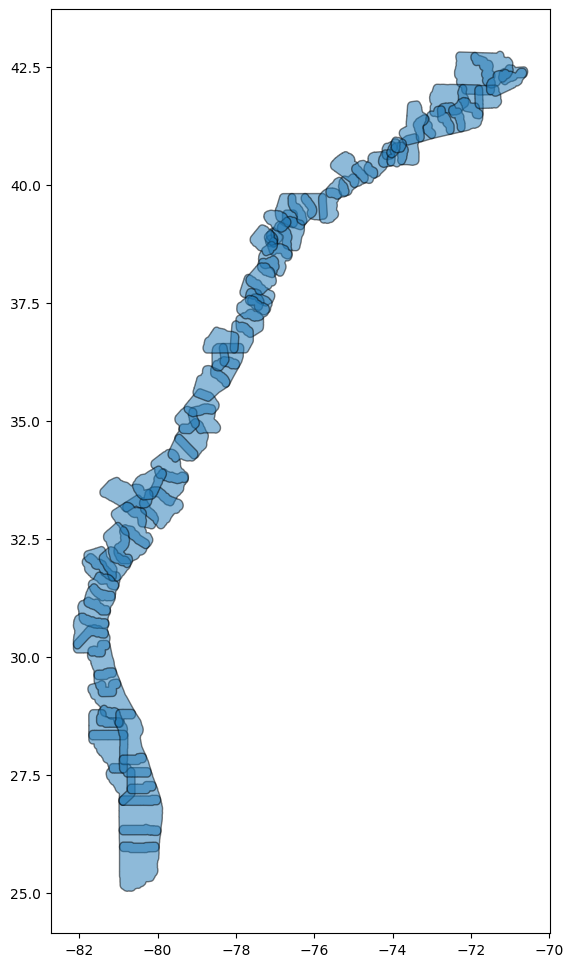

In [3]:
buffered.plot(figsize=(10, 12), edgecolor='black', alpha=0.5)

In [4]:
import geopandas as gpd
from shapely.geometry import LineString
import shapely
import numpy as np

# Load the simplified I-95 route
i95 = gpd.read_file("i95_route.geojson")

# Reproject to a metric CRS for accurate distance
i95 = i95.to_crs("EPSG:3857")  # Units: meters

# Set segment length in meters (100 km)
segment_length = 100_000

# Extract the line geometry
line: LineString = i95.geometry.iloc[0]
line_length = line.length

# Generate equally spaced points along the line
num_segments = int(line_length // segment_length)
distances = np.linspace(0, line_length, num_segments + 1)

# Create segment geometries
segments = []
for i in range(len(distances) - 1):
    start = distances[i]
    end = distances[i + 1]
    segment = shapely.ops.substring(line, start, end)
    segments.append(segment)

# Convert to GeoDataFrame
segments_gdf = gpd.GeoDataFrame(geometry=segments, crs=i95.crs)

# Buffer each segment to create a "zone" (e.g., 30 km wide)
segments_gdf["geometry"] = segments_gdf.buffer(30_000)  # 30 km buffer

# Reproject back to WGS84 (lat/lon) for export or Folium
segments_gdf = segments_gdf.to_crs("EPSG:4326")

# Save to GeoJSON
segments_gdf.to_file("i95_stopover_zones.geojson", driver="GeoJSON")

print("✅ Segmented and buffered I-95 stopover zones saved to 'i95_stopover_zones.geojson'.")


✅ Segmented and buffered I-95 stopover zones saved to 'i95_stopover_zones.geojson'.


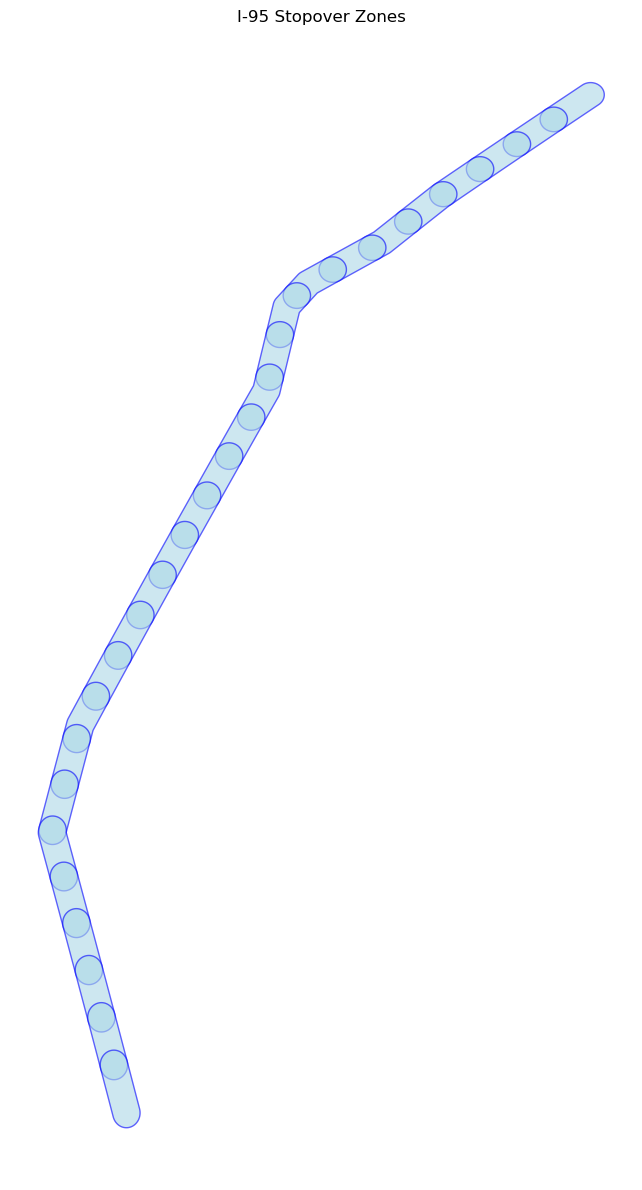

In [5]:
import geopandas as gpd

import matplotlib.pyplot as plt

# Load the stopover zones GeoJSON
zones_gdf = gpd.read_file("i95_stopover_zones.geojson")

# Plot the stopover zones
fig, ax = plt.subplots(figsize=(10, 12))
zones_gdf.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.6)
plt.title("I-95 Stopover Zones")
plt.axis("off")
plt.tight_layout()
plt.show()

In [33]:
# !pip install folium

In [6]:
import folium
import geopandas as gpd

# Load the buffered stopover zones
zones = gpd.read_file("i95_stopover_zones.geojson")

# Get centroid to center the map
center = zones.geometry.unary_union.centroid
map_center = [center.y, center.x]

# Create folium map
m = folium.Map(location=map_center, zoom_start=6, tiles="CartoDB Positron")

# Add zones as a GeoJson layer
folium.GeoJson(
    zones,
    name="I-95 Stopover Zones",
    style_function=lambda feature: {
        'fillColor': '#ff7800',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.4
    }
).add_to(m)

# Add layer control and show map
folium.LayerControl().add_to(m)

# Save or display
m.save("i95_zones_map.html")
print("✅ Map saved as 'i95_zones_map.html'. Open it in your browser.")


✅ Map saved as 'i95_zones_map.html'. Open it in your browser.


C:\Users\marthalc\AppData\Local\Temp\ipykernel_43804\3379899451.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = zones.geometry.unary_union.centroid


In [7]:
from shapely.geometry import Point

def assign_zone_to_point(lon, lat, zones_gdf):
    """
    Assign a stopover zone to a point based on longitude and latitude.

    Parameters:
        lon (float): Longitude of the point.
        lat (float): Latitude of the point.
        zones_gdf (GeoDataFrame): GeoDataFrame of stopover zones (must be in EPSG:4326).

    Returns:
        int or None: Index of the matching zone in zones_gdf, or None if not found.
    """

    point = Point(lon, lat)
    match = zones_gdf[zones_gdf.geometry.contains(point)]
    if not match.empty:
        return match.index[0]
    return None

In [8]:
import pandas as pd

# Load the Motus detections CSV
motus_df = pd.read_csv("Motus-data-species-16820_detections_downloaded-2025-06-03.csv")

# Assign zone index to each detection
motus_df["zone_index"] = motus_df.apply(
    lambda row: assign_zone_to_point(row["lon"], row["lat"], zones), axis=1
)

# Save to CSV
motus_df.to_csv("Motus-data-with-zones.csv", index=False)

motus_df.head()

,tagDeployID,species,lon,lat,stationID,previousStationID,stationName,previousStationName,tsStart,tsEnd,travelDurationHours,travelDistanceKMs,speedKmH,stopoverDurationHours,tagProjectID,tagFrequency,Unnamed: 16,Unnamed: 17,Unnamed: 18,zone_index
0,53,Blackpoll Warbler,-72.5381,42.8551,11172,Deployment site,Wantastiquet,Missing data,12 Oct 2015 01:09:58 GMT,14 Oct 2015 07:03:09 GMT,53886.1,NaN,NaN,0.2,74.0,166.38,NaN,NaN,NaN,NaN
1,53,Blackpoll Warbler,-72.5381,42.8551,11172,11172,Wantastiquet,Wantastiquet,12 Oct 2015 01:09:58 GMT,14 Oct 2015 07:03:09 GMT,0.2,NaN,NaN,0.2,74.0,166.38,NaN,NaN,NaN,NaN
2,53,Blackpoll Warbler,-72.5381,42.8551,11062,11172,GB_ferry_way,Wantastiquet,21 Oct 2015 19:22:43 GMT,22 Oct 2015 23:54:34 GMT,28.5,140,4.2,NaN,74.0,166.38,NaN,NaN,NaN,NaN
3,53,Blackpoll Warbler,-70.8522,43.0899,11537,11062,PKR_salt_pannes,GB_ferry_way,23 Oct 2015 00:04:07 GMT,23 Oct 2015 01:14:19 GMT,1.2,35,12.5,NaN,74.0,166.38,NaN,NaN,NaN,NaN
4,53,Blackpoll Warbler,-70.8084,42.7804,11536,11537,PKR_nelson,PKR_salt_pannes,23 Oct 2015 01:19:00 GMT,23 Oct 2015 07:03:10 GMT,5.7,4,NaN,NaN,74.0,166.38,NaN,NaN,NaN,NaN


In [9]:
# Count the number of detections in each zone_index
zone_counts = motus_df.groupby("zone_index").count()["tagDeployID"]
print(zone_counts)

zone_index
0.0     8
2.0     2
5.0     2
6.0     3
7.0     1
16.0    1
19.0    9
20.0    8
21.0    3
25.0    5
Name: tagDeployID, dtype: int64
